In [1]:
#from google.colab import drive
#from google.colab import files
#drive.mount('/content/drive', force_remount=True)

In [2]:
#!pip install --upgrade kaggle > /dev/null 2>&1
#!pip install optuna  > /dev/null 2>&1

In [3]:
# move kaggle.json into the folder where the API expects to find it
#!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

***

In [4]:
from glob import glob
import numpy as np
import pandas as pd
import scipy.interpolate
import scipy.sparse
from tqdm import tqdm
from joblib import Parallel,delayed
import yaml

from scipy.spatial import distance
import matplotlib.pyplot as plt
import seaborn as sns

***

In [5]:
def mean_position_error(labels, preds):
    x_label = labels.x.values
    y_label = labels.y.values
    x_pred = preds.x.values
    y_pred = preds.y.values
    return np.mean(np.sqrt((x_label-x_pred)**2 + (y_label-y_pred)**2))

***

In [6]:
!kaggle datasets download -d mavillan/iln-imu-preds --force --unzip

100%|███████████████████████████████████████▉| 471M/471M [00:47<00:00, 11.5MB/s]
100%|████████████████████████████████████████| 471M/471M [00:47<00:00, 10.3MB/s]


In [7]:
!kaggle datasets download -d mavillan/iln-dnn-dset1 --force --unzip

100%|███████████████████████████████████████▉| 152M/152M [00:16<00:00, 11.5MB/s]
100%|████████████████████████████████████████| 152M/152M [00:16<00:00, 9.76MB/s]


In [24]:
!kaggle datasets download -d mavillan/iln-ds1-30f-5lt --force --unzip

100%|███████████████████████████████████████▊| 239M/240M [00:24<00:00, 10.1MB/s]
100%|████████████████████████████████████████| 240M/240M [00:24<00:00, 10.5MB/s]


In [6]:
# get floors for each waypoint in train
floors = list()
for file in glob("./train/*.parquet"):
    df = pd.read_parquet(file)
    floors.append(df.loc[:,["site","path","floor"]].drop_duplicates())
floors = pd.concat(floors, ignore_index=True)

In [7]:
input_path = "./dnn-ds1-30f-5lt-pl"

predictions = (
    pd.read_csv(f"{input_path}/oof_preds_stg.csv", index_col=0)
    .merge(floors, how="inner", on=["site","path"])
    .reset_index(drop=True)
)

labels = (
    pd.read_csv(f"{input_path}/oof_preds.csv")
    .loc[:,["site","path","timestamp","x","y"]]
    .drop_duplicates()
    .merge(floors, how="inner", on=["site","path"])
    .reset_index(drop=True)
)

In [8]:
waypoints = pd.read_csv("waypoints.csv").merge(floors, how="inner", on=["site","path"])
waypoints_aug = pd.read_csv("pos_preds.csv").merge(floors, how="inner", on=["site","path"])

In [9]:
predictions = predictions.sort_values(["site","path","timestamp"], ignore_index=True)
labels = labels.sort_values(["site","path","timestamp"], ignore_index=True)

In [10]:
target_sites = predictions.site.unique().tolist()

***
## optimization of parameters: by site

In [11]:
# adds closest waypoint and distance
all_preds = list()
use_augmented = False

for (site,floor),preds_slice in predictions.groupby(["site","floor"]):
    if use_augmented:
        waypoints_slice = waypoints_aug.query("site==@site & floor==@floor")
    else:
        waypoints_slice = waypoints.query("site==@site & floor==@floor")
    dist_matrix = distance.cdist(preds_slice[["x","y"]].values, waypoints_slice[["x","y"]].values)
    idx_min = np.argmin(dist_matrix, axis=1)
    closest_wp = waypoints_slice[["x","y"]].values[idx_min]
    closest_wp_dist = np.min(dist_matrix, axis=1)
    
    preds_slice["x_wp"] = closest_wp[:,0]
    preds_slice["y_wp"] = closest_wp[:,1]
    preds_slice["dist"] = closest_wp_dist
    all_preds.append(preds_slice)
    
predictions = pd.concat(all_preds, ignore_index=True).sort_values(["site","path","timestamp"])

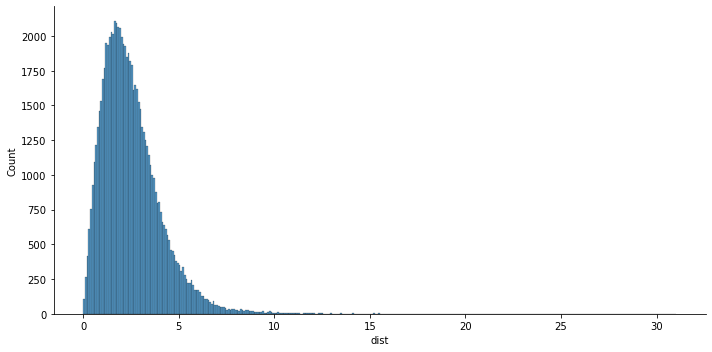

In [12]:
# hist of min distances to waypoints
sns.displot(predictions.dist, aspect=2)

In [13]:
def apply_stg(predictions, threshold=5):
    predictions = predictions.copy(deep=True)
    idx_to_snap = predictions.query("dist < @threshold").index
    predictions.loc[idx_to_snap,"x"] = predictions.loc[idx_to_snap,"x_wp"]
    predictions.loc[idx_to_snap,"y"] = predictions.loc[idx_to_snap,"y_wp"]
    return predictions

100%|██████████| 1401/1401 [00:04<00:00, 315.57it/s]


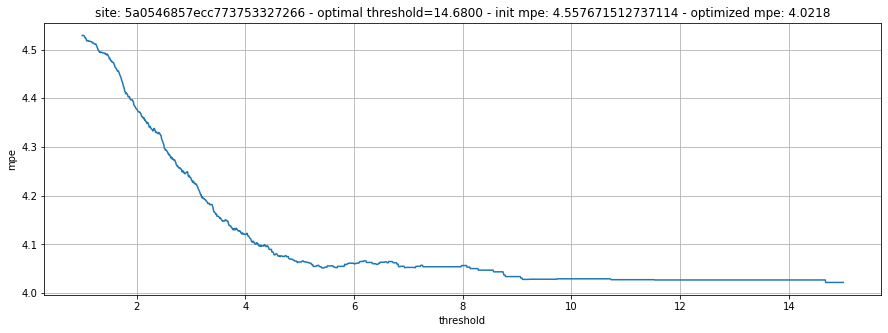

100%|██████████| 1401/1401 [00:04<00:00, 321.63it/s]


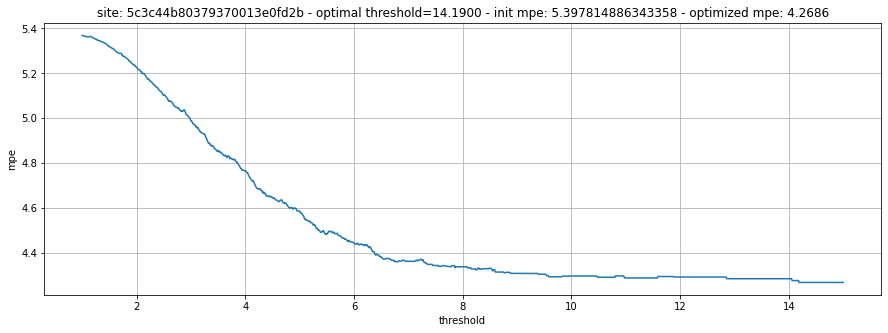

100%|██████████| 1401/1401 [00:05<00:00, 245.35it/s]


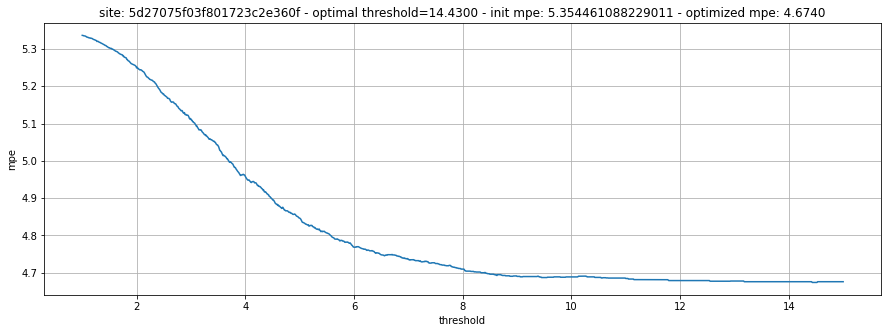

100%|██████████| 1401/1401 [00:04<00:00, 315.60it/s]


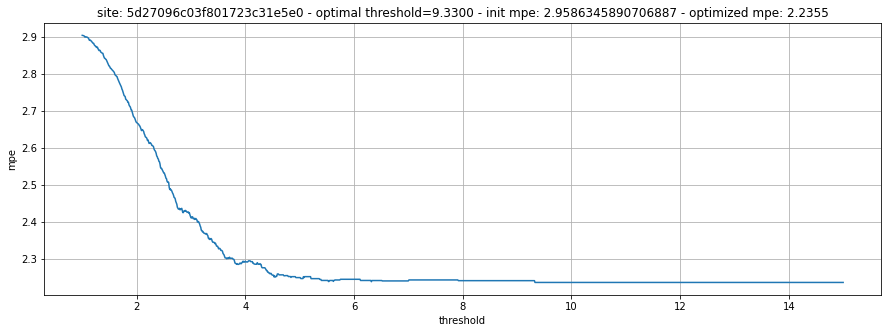

100%|██████████| 1401/1401 [00:04<00:00, 326.79it/s]


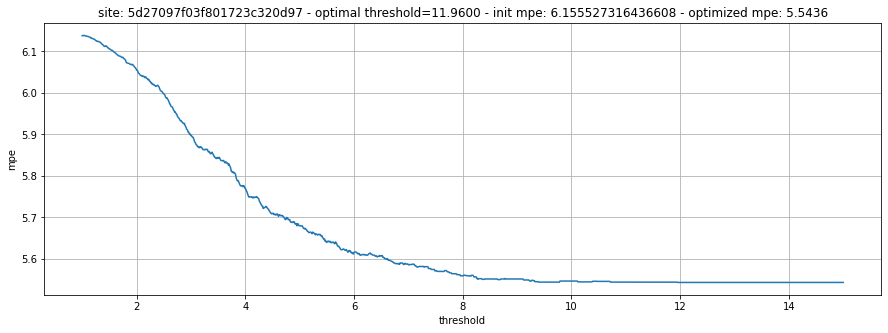

100%|██████████| 1401/1401 [00:03<00:00, 380.22it/s]


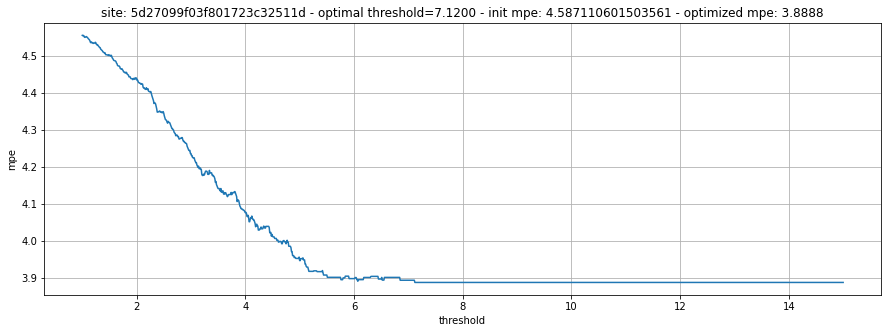

100%|██████████| 1401/1401 [00:04<00:00, 329.51it/s]


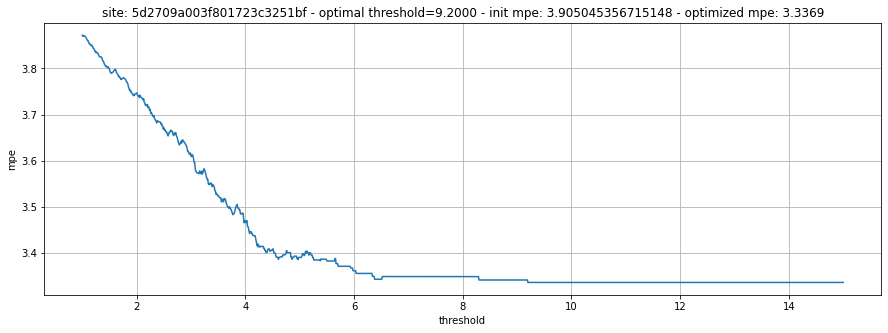

100%|██████████| 1401/1401 [00:04<00:00, 343.78it/s]


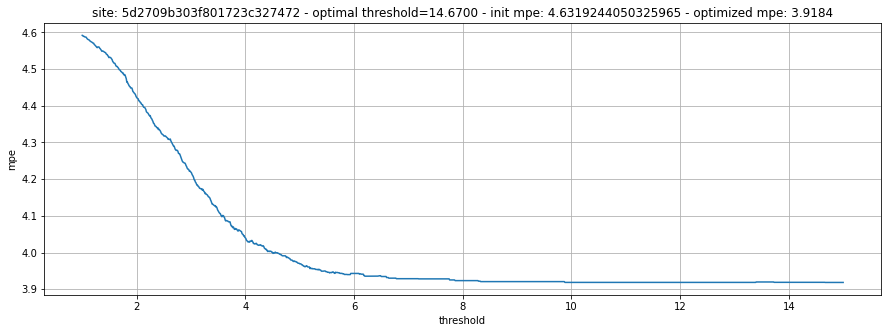

100%|██████████| 1401/1401 [00:04<00:00, 322.07it/s]


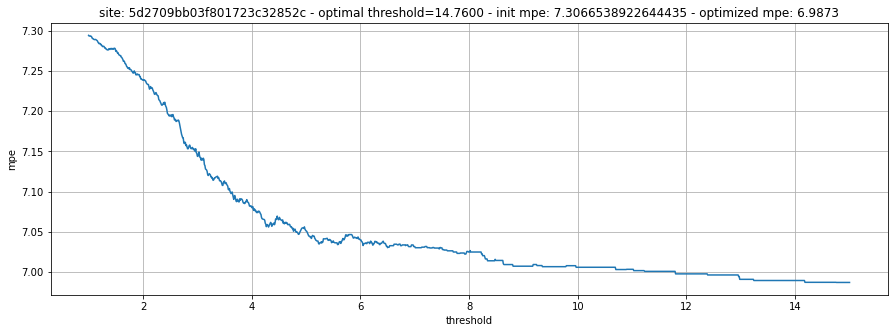

100%|██████████| 1401/1401 [00:04<00:00, 308.99it/s]


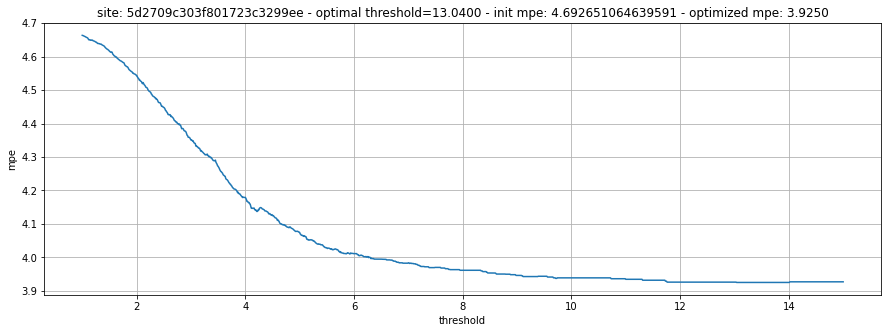

100%|██████████| 1401/1401 [00:04<00:00, 348.45it/s]


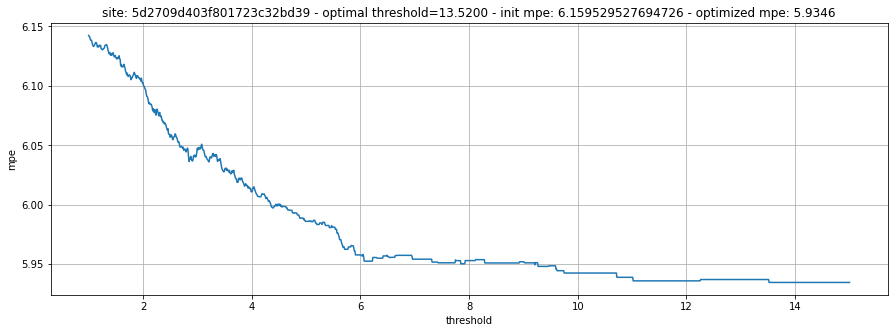

100%|██████████| 1401/1401 [00:03<00:00, 375.23it/s]


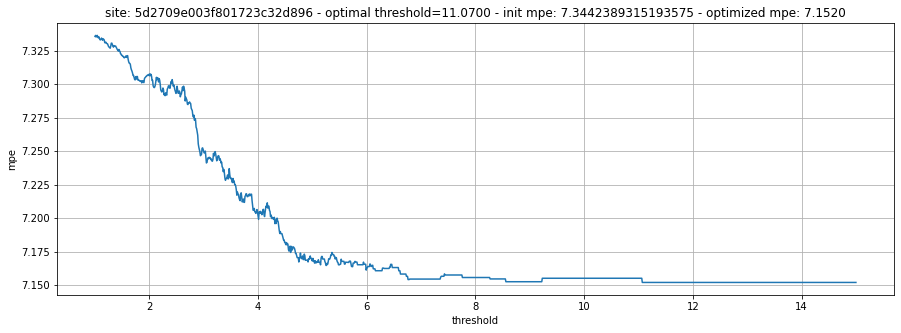

100%|██████████| 1401/1401 [00:03<00:00, 400.12it/s]


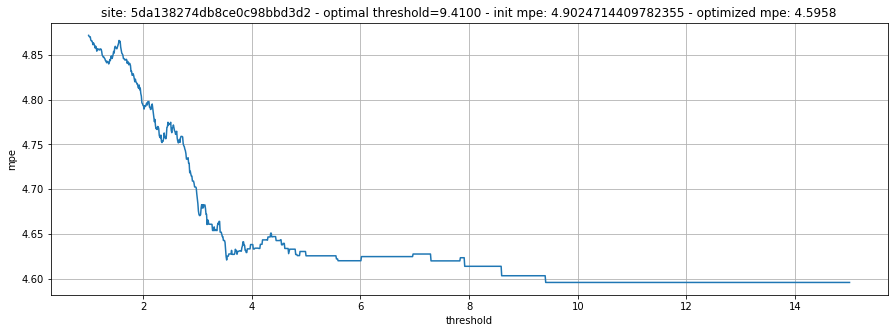

100%|██████████| 1401/1401 [00:03<00:00, 364.06it/s]


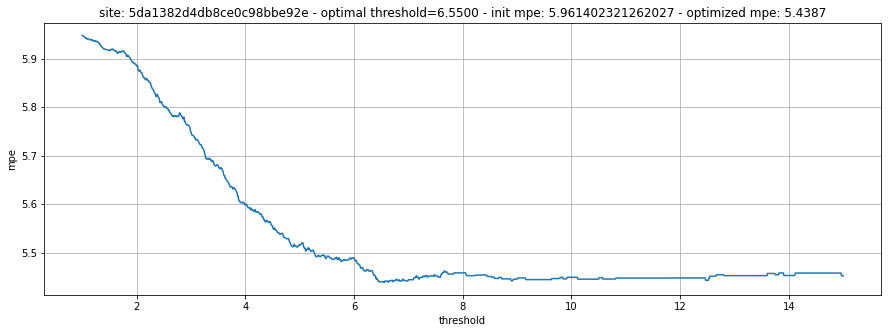

100%|██████████| 1401/1401 [00:04<00:00, 343.55it/s]


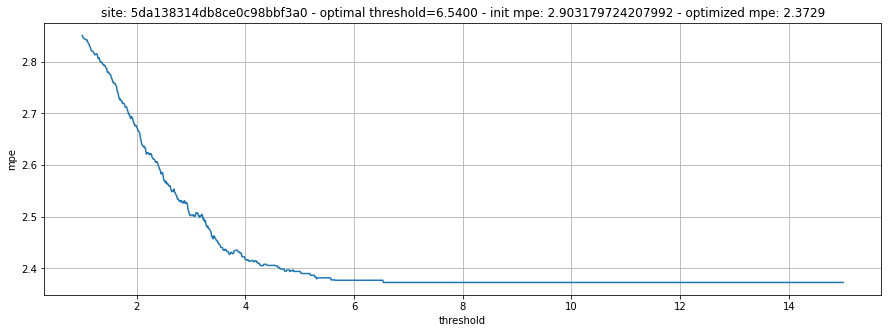

100%|██████████| 1401/1401 [00:03<00:00, 368.16it/s]


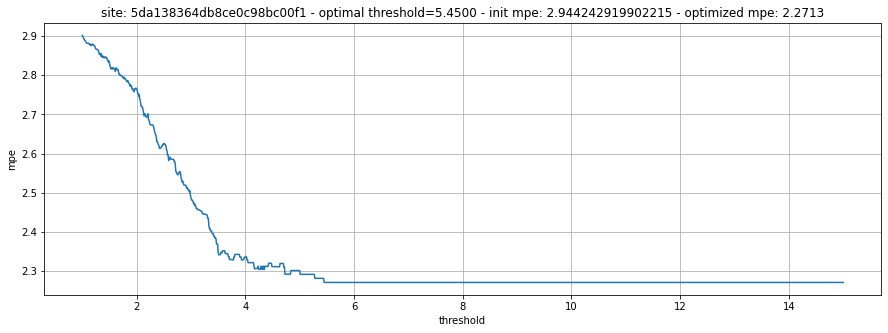

100%|██████████| 1401/1401 [00:04<00:00, 309.36it/s]


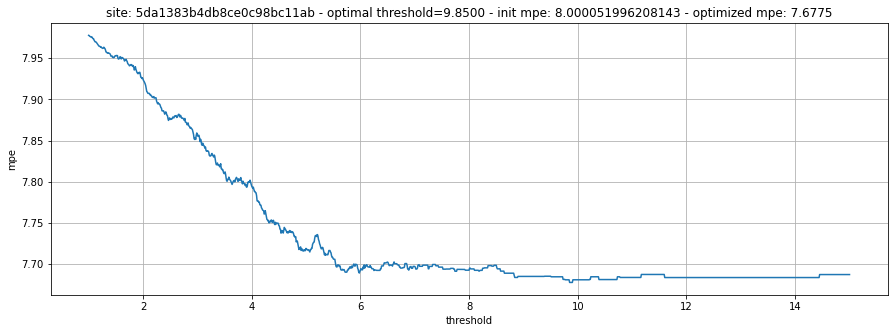

100%|██████████| 1401/1401 [00:03<00:00, 397.56it/s]


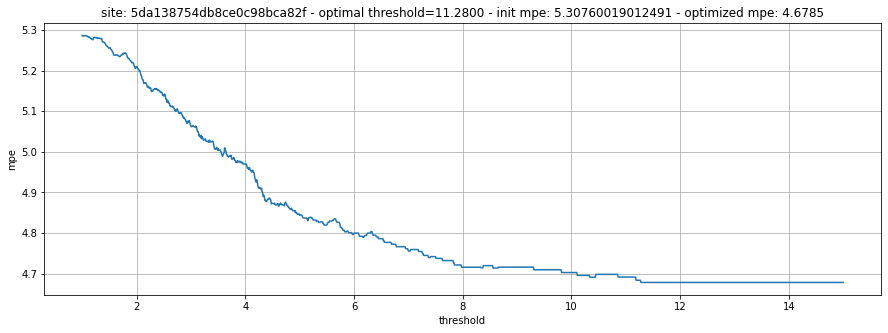

100%|██████████| 1401/1401 [00:04<00:00, 327.46it/s]


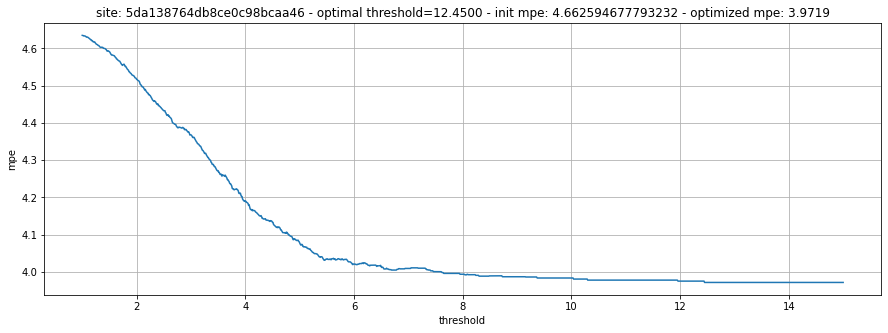

100%|██████████| 1401/1401 [00:04<00:00, 307.25it/s]


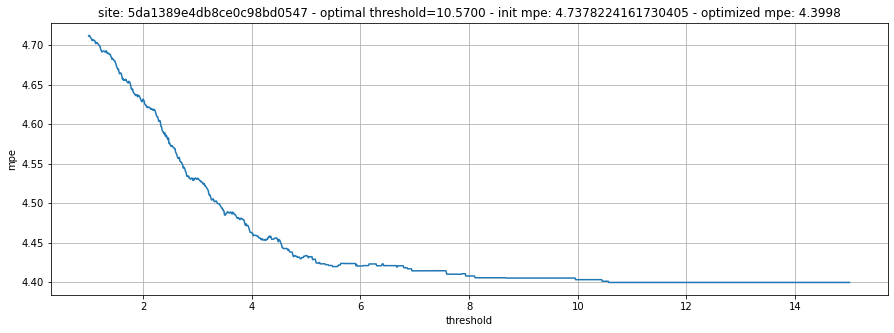

100%|██████████| 1401/1401 [00:04<00:00, 307.79it/s]


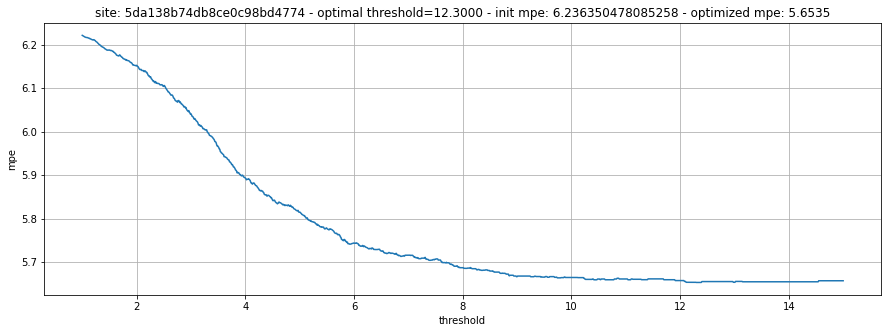

100%|██████████| 1401/1401 [00:04<00:00, 299.42it/s]


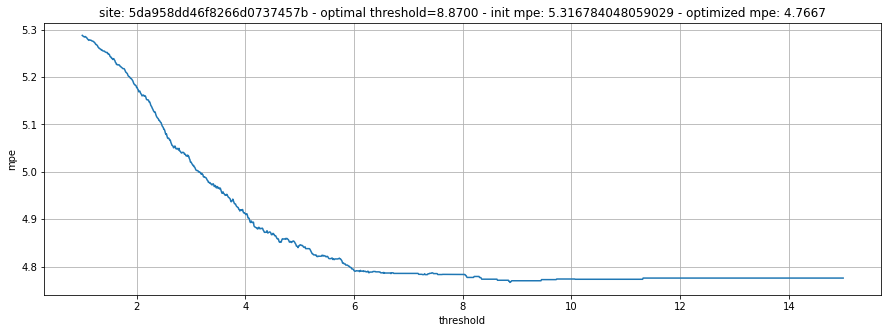

100%|██████████| 1401/1401 [00:04<00:00, 280.24it/s]


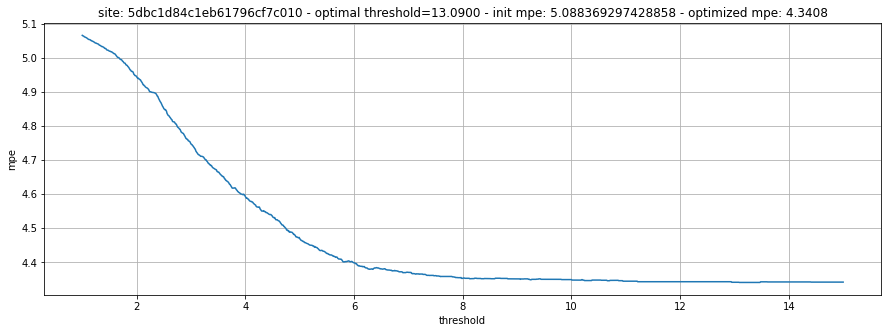

100%|██████████| 1401/1401 [00:04<00:00, 318.55it/s]


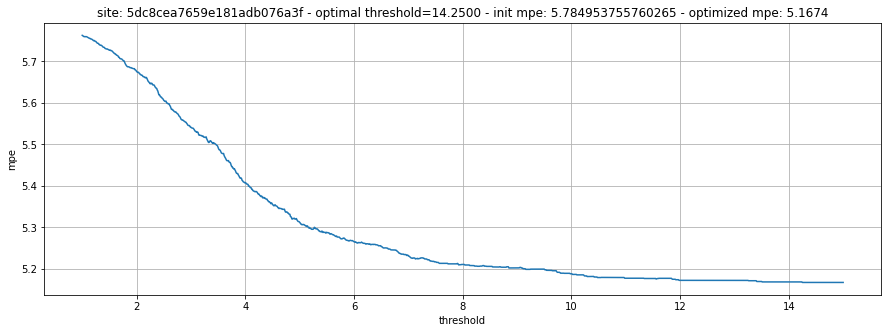

In [14]:
threshold_values = np.arange(1, 15.01, 0.01)

best_threshold_by_site = dict()
all_snap = list()

for site in np.sort(target_sites):
    
    site_preds = predictions.query("site == @site")
    site_labels = labels.query("site == @site")
    
    mpe_i = mean_position_error(site_labels,site_preds)
    
    mpe_list = list()
    for threshold in tqdm(threshold_values):
        site_preds_stg = apply_stg(site_preds, threshold=threshold)
        mpe = mean_position_error(site_labels, site_preds_stg)
        mpe_list.append(mpe)
    mpe_arr = np.asarray(mpe_list)
    idx_min = np.argmin(mpe_arr)
    opt_thr = threshold_values[idx_min]
    opt_mpe = mpe_arr[idx_min]
    
    best_threshold_by_site[site] = opt_thr
    all_snap.append(apply_stg(site_preds, threshold=opt_thr))
    
    plt.figure(figsize=(15,5))
    plt.plot(threshold_values, mpe_arr)
    plt.xlabel("threshold")
    plt.ylabel("mpe")
    plt.title(f"site: {site} - optimal threshold={opt_thr:0.4f} - init mpe: {mpe_i} - optimized mpe: {opt_mpe:0.4f}")
    plt.grid()
    plt.show()

In [15]:
predictions_snap = pd.concat(all_snap, ignore_index=True)

In [16]:
# inital mpe
mean_position_error(labels, predictions)

5.492992240101407

In [17]:
# mpe after snap to grid with best threshold by site
mean_position_error(labels, predictions_snap)

4.911407848762689

In [18]:
best_threshold_by_site

{'5a0546857ecc773753327266': 14.680000000000012,
 '5c3c44b80379370013e0fd2b': 14.190000000000012,
 '5d27075f03f801723c2e360f': 14.430000000000012,
 '5d27096c03f801723c31e5e0': 9.330000000000007,
 '5d27097f03f801723c320d97': 11.96000000000001,
 '5d27099f03f801723c32511d': 7.120000000000005,
 '5d2709a003f801723c3251bf': 9.200000000000006,
 '5d2709b303f801723c327472': 14.670000000000012,
 '5d2709bb03f801723c32852c': 14.760000000000012,
 '5d2709c303f801723c3299ee': 13.04000000000001,
 '5d2709d403f801723c32bd39': 13.52000000000001,
 '5d2709e003f801723c32d896': 11.07000000000001,
 '5da138274db8ce0c98bbd3d2': 9.410000000000007,
 '5da1382d4db8ce0c98bbe92e': 6.550000000000005,
 '5da138314db8ce0c98bbf3a0': 6.5400000000000045,
 '5da138364db8ce0c98bc00f1': 5.450000000000004,
 '5da1383b4db8ce0c98bc11ab': 9.850000000000009,
 '5da138754db8ce0c98bca82f': 11.280000000000008,
 '5da138764db8ce0c98bcaa46': 12.45000000000001,
 '5da1389e4db8ce0c98bd0547': 10.57000000000001,
 '5da138b74db8ce0c98bd4774': 12.3

***
## optimization of parameters: jointly

In [19]:
threshold_values = np.arange(1, 15.01, 0.01)
mpe_list = list()

for threshold in tqdm(threshold_values):
    predictions_stg = apply_stg(predictions, threshold=threshold)
    mpe = mean_position_error(labels, predictions_stg)
    mpe_list.append(mpe)
    
mpe_arr = np.asarray(mpe_list)
idx_min = np.argmin(mpe_arr)

100%|██████████| 1401/1401 [00:20<00:00, 68.97it/s]


In [20]:
mean_position_error(labels, predictions)

5.492992240101407

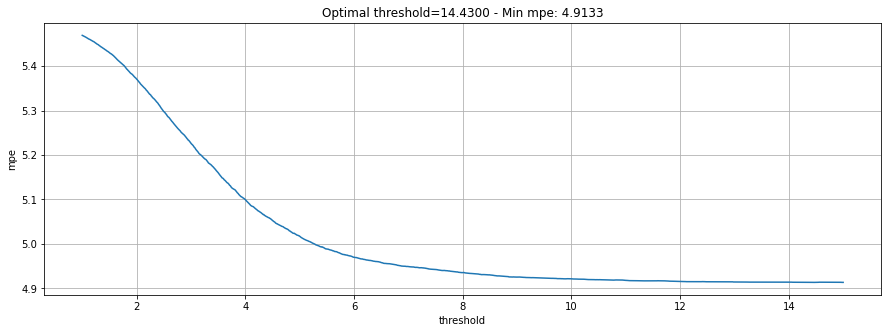

In [21]:
opt_thr = threshold_values[idx_min]
opt_mpe = mpe_arr[idx_min]

plt.figure(figsize=(15,5))
plt.plot(threshold_values, mpe_arr)
plt.xlabel("threshold")
plt.ylabel("mpe")
plt.title(f"Optimal threshold={opt_thr:0.4f} - Min mpe: {opt_mpe:0.4f}")
plt.grid()

***